# Analysis of Recidivism Rates in Iowa

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
pd.options.mode.chained_assignment = None

import recidivism_tools # my own package

/Users/nickmelamed/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('../data/Iowa_Prison_Recidivism_Status__Current_Cohort.csv')
df.head(5)

,Race,Sex,Age,Supervising Unit,Supervision Type,Cohort Fiscal Year,Report Fiscal Year,Supervision Start Date,Supervision End Date,Months Supervised,...,Supervision Offense Subtype,Reincarcerated,Reincarcerated Reason,Survival Time (Days),Survival Time (Months),Reincarcerated Offense Code,Reincarcerated Offense Class,Reincarcerated Offense Type,Reincarcerated Offense Subtype,Risk Ranking
0,White,Male,39,Newton Correctional Facility,Prison,2019,2022,05/19/2014,07/08/2018,49,...,Sex,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,White,Male,59,Districts/Compact Regions,Work Release,2019,2022,03/22/2018,07/19/2018,3,...,Trafficking,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low
2,White,Female,40,Districts/Compact Regions,Work Release,2019,2022,10/12/2018,11/20/2018,1,...,Sex,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low
3,White,Male,53,Iowa Medical & Classification Center,Prison,2019,2022,09/08/2017,10/18/2018,13,...,Assault,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low
4,White,Male,53,Fort Dodge Correctional Facility,Prison,2019,2022,10/04/2018,05/08/2019,7,...,Drug Possession,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Moderate


In [3]:
df.columns

Index(['Race', 'Sex', 'Age', 'Supervising Unit', 'Supervision Type',
       'Cohort Fiscal Year', 'Report Fiscal Year', 'Supervision Start Date',
       'Supervision End Date', 'Months Supervised', 'Supervision End Reason',
       'Charge ID [Internal]', 'Supervision Offense Class',
       'Supervision Offense Type', 'Supervision Offense Subtype',
       'Reincarcerated', 'Reincarcerated Reason', 'Survival Time (Days)',
       'Survival Time (Months)', 'Reincarcerated Offense Code',
       'Reincarcerated Offense Class', 'Reincarcerated Offense Type',
       'Reincarcerated Offense Subtype', 'Risk Ranking'],
      dtype='object')

## 1. What goes into a Risk Ranking: Logistic Regression Analysis

### Background, Data Preparation, and Methodology

As shown in our dataset, the individuals are assigned a risk ranking, which corresponds to their perceived odds of reoffense. There are 3 categories: Low, Moderate, and High. 

As mentioned in our overview, in an ideal world, if we condition on an immutable characteristic such as race, we would see no difference in risk ranking. Obviously, the race of an incarcerated individual does not inherently contribute to the risk of reoffense.

Is this what happens in reality? Is Risk Ranking consistent across immutable characteristics when accounting for other determinants such as the type of offense? 

To get a better idea of what's going on, let's examine which factors have the most influence over risk ranking.

In [4]:
risk = df.loc[~df['Risk Ranking'].isna(), ['Race', 'Sex', 'Age', 'Supervising Unit',
           'Supervision Type', 'Months Supervised', 'Supervision Offense Type', 'Risk Ranking']]

Note that since risk ranking is determined before release, we ignore any factors related to post-release activity or anything else that is independent of determining risk ranking. We also will not include redundant variables while trying to strike a balance between granularity and number of features (e.g., picking **Supervision Offense Type** instead of **Class** (too broad) or **Subtype** (too specific). We remove all columns that do not have an assigned Risk Ranking. <br><br>
We will perform a logistic regression below to analyze the impact of these factors. I chose a logistic regression because we are interested in predicting a set of defined outcomes and understanding the likelihood of these outcomes occurring. To avoid multicollinearity, and due to the sheer size of the data, I will be performing individual multinomial regressions for each of the Risk Ranking levels. We will binarize all of our categorical predictors (every column in our risk DataFrame except **Age** and **Months Supervised**) since regression does not accept categorical variables. <br><br>

In [5]:
factors = ['Race', 'Sex', 'Age', 'Supervising Unit', 'Supervision Type', 'Months Supervised', 'Supervision Offense Type']
rankings = risk['Risk Ranking']

risk_dummy = pd.get_dummies(risk, columns = factors, prefix_sep = ": ")
risk_dummy.head()

,Risk Ranking,Race: American Indian or Alaska Native,Race: Asian or Pacific Islander,Race: Black,Race: Hispanic,Race: White,Sex: Female,Sex: Male,Age: 18,Age: 19,...,Months Supervised: 218,Months Supervised: 219,Months Supervised: 225,Months Supervised: 256,Months Supervised: 482,Supervision Offense Type: Drug,Supervision Offense Type: Other,Supervision Offense Type: Property,Supervision Offense Type: Public Order,Supervision Offense Type: Violent
1,Low,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Low,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Low,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Moderate,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
5,High,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [6]:
len(risk_dummy.columns)

186

In [7]:
risk['Age'].unique()

array([59, 40, 53, 39, 56, 55, 54, 44, 41, 42, 46, 68, 66, 45, 51, 58, 57,
       60, 52, 50, 61, 49, 62, 63, 48, 65, 47, 64, 67, 35, 38, 36, 69, 43,
       37, 27, 70, 34, 30, 26, 29, 31, 28, 33, 23, 21, 32, 19, 24, 25, 20,
       22, 74, 18, 82, 71, 78])

In [8]:
risk['Months Supervised'].unique()

array([  3,   1,  13,   7,   0,  20,   2,   4,   8,   6,  10,   5,  25,
         9,  15,  36,  43,  18,  22,  21,  16,  11,  19,  72,  27,  24,
        12,  28,  56,  14,  34,  17,  39,  70, 218,  32,  41, 256,  23,
        54,  31, 482,  42,  58,  52,  26,  33,  48,  38, 215,  73,  29,
        75,  95,  51,  50,  74,  30,  40, 132, 225, 102,  60, 123,  76,
        45,  59, 219,  46,  47,  62,  89, 100, 163,  55, 120,  57,  64,
        91,  94,  44,  49, 111,  77, 168,  61,  53,  35,  68,  37, 144,
       107,  97,  78,  79, 186,  83,  67, 141,  65, 194,  66,  88])

As we can see above, we have a lot of binary variables (186 to be exact)! This is likely going to overrun my laptop, in addition to the risk of overfitting our model. To top it all off, this granularity is likely unnecessary; we would have reason to believe ages 44 and 45 don't dramatically change the risk ranking of an individual). To remove these redundancies while still maintaining a satisfactory level of granularity, we will be grouping our **Months Supervised** and **Age** variables. The following will be the groups: 

Months Supervised: 0-24, 25-48, 49-120, 121-240

Age: 18-25, 26-29, 30-39, 40-49, 50-59, 60-89. 

Note that the groupings are fairly arbitrary, as I based them mostly off of intuition (i.e., people in the age 18-25 age group would have different behavior than 26-29) in the absence of research done on more granular age rankings. The United States Sentencing Commission's report on the impact of age on risk of recidivism, linked [here](https://www.ussc.gov/sites/default/files/pdf/research-and-publications/research-publications/2017/20171207_Recidivism-Age.pdf), only shows results on the grouping of 30 or younger or 60 or older, for instance. The same report did not offer much in terms of grouping by sentence length. So, we proceed with these groupings with the understanding that they are likely not perfect.

In [9]:
less_dummies = pd.DataFrame() # new DF to contain groupings of Age, Months Supervised

for months in [(0,24), (25,48), (49,120), (121,240)]:
    recidivism_tools.create_dummy_range(months[0], months[1], risk, less_dummies, 'Months Supervised')

for years in [(18,25), (26,29), (30,39), (40,49), (50,59), (60,89)]:
    recidivism_tools.create_dummy_range(years[0], years[1], risk, less_dummies, 'Age')

less_dummies.head(5)

,Months Supervised: 0-24,Months Supervised: 25-48,Months Supervised: 49-120,Months Supervised: 121-240,Age: 18-25,Age: 26-29,Age: 30-39,Age: 40-49,Age: 50-59,Age: 60-89
1,1,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,1,0
5,1,0,0,0,0,0,1,0,0,0


Now we combine our new "grouped dummies" dataframe with our our original dataframe so we may begin our analysis:

In [10]:
original_dummies = ['Race', 'Sex', 'Supervision Offense Type', 'Supervising Unit', 'Supervision Type']
kept_dummies = pd.get_dummies(risk[['Risk Ranking'] + original_dummies], columns = original_dummies, prefix_sep = ": ")


risk_less_dummies = pd.concat([kept_dummies, less_dummies], axis = 1)
risk_less_dummies.head(5)

,Risk Ranking,Race: American Indian or Alaska Native,Race: Asian or Pacific Islander,Race: Black,Race: Hispanic,Race: White,Sex: Female,Sex: Male,Supervision Offense Type: Drug,Supervision Offense Type: Other,...,Months Supervised: 0-24,Months Supervised: 25-48,Months Supervised: 49-120,Months Supervised: 121-240,Age: 18-25,Age: 26-29,Age: 30-39,Age: 40-49,Age: 50-59,Age: 60-89
1,Low,0,0,0,0,1,0,1,1,0,...,1,0,0,0,0,0,0,0,1,0
2,Low,0,0,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,Low,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
4,Moderate,0,0,0,0,1,0,1,1,0,...,1,0,0,0,0,0,0,0,1,0
5,High,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0


### Multinomial Regression Analysis

Note that for our multinomial regression, the baseline comparison for risk ranking is going to be for the High Risk ranking. In addition, our multinomial regression will return coefficients that must be converted to an odds ratio. This is critical for the following coefficient interpretations. For instance, if the converted coefficient of Months supervised: 0-24 for the Low risk ranking is ranking is 0.75, that means the chance of being a low risk ranking given an individual was supervised for 0-24 months is 0.75x as likely as being a High risk ranking.

Also, for the coefficient dataframes, note that 0 corresponds to the Low risk ranking, and 1 to the Moderate ranking.

In [11]:
mlr = recidivism_tools.dummy_mlr('Race', risk_less_dummies)
print(mlr.summary())

Optimization terminated successfully.
         Current function value: 0.997302
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:           Risk Ranking   No. Observations:                 5028
Model:                        MNLogit   Df Residuals:                     5018
Method:                           MLE   Df Model:                            8
Date:                Tue, 21 Nov 2023   Pseudo R-squ.:                 0.01186
Time:                        10:49:35   Log-Likelihood:                -5014.4
converged:                       True   LL-Null:                       -5074.6
Covariance Type:            nonrobust   LLR p-value:                 2.779e-22
                      Risk Ranking=Low       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Race: American Indian or Alaska Native    -0.4336   

Note in order to interpret our coefficient, we must convert to the odds ratio, which we do by exponentiating the given coefficients. We can then view these new coefficients as the ratio of the chance an individual from the given category will be assigned the given risk ranking compared to the chance of being assigned a High Risk ranking. Therefore, higher values would correspond to a higher chance of being assigned the given ranking (either Low or Moderate), lower correspond to a higher chance of being assigned a High ranking.

In [12]:
mlr.params.apply(np.exp)

,0,1
Race: American Indian or Alaska Native,0.648148,0.296296
Race: Asian or Pacific Islander,1.266667,0.600000
Race: Black,0.357585,0.272446
Race: Hispanic,0.635036,0.313869
Race: White,0.860062,0.344272


Based on these ratios, the lowest odds of being named Low or Moderate Risk Ranking are Black individuals. The highest odds of being named Low or Moderate belong to AAPI. Note that each group, with the exception of AAPI for Low Rankings, have a higher odds of being named to High risk ranking. This is an interesting finding that may be due to the prevalence of different covariates that we aren't accounting for here, perhaps in Supervision Facility or Supervision Offense Type. 

Either way, we obtain statistically significant coefficients for everyone except for AAPI in both Low and Moderate risk ranking, but we see some overlap in the confidence intervals for some of our statistics, including: American Indian or Alaska Native, AAPI, and Hispanic and White for Low and Moderate risk, and Black with the aforementioned categories for Moderate risk. Therefore, we have evidence to suggest there is a differential between Black and non-Black individuals for being assigned Low risk as opposed to high, which is concerning and warrants further evaluation of the criteria and deeper research (ideally modeling this situation accounting for covariates) to determine the severity of this claim.

In [13]:
mlr = recidivism_tools.dummy_mlr('Sex', risk_less_dummies)
print(mlr.summary())

Optimization terminated successfully.
         Current function value: 0.986081
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:           Risk Ranking   No. Observations:                 5028
Model:                        MNLogit   Df Residuals:                     5024
Method:                           MLE   Df Model:                            2
Date:                Tue, 21 Nov 2023   Pseudo R-squ.:                 0.02298
Time:                        10:49:35   Log-Likelihood:                -4958.0
converged:                       True   LL-Null:                       -5074.6
Covariance Type:            nonrobust   LLR p-value:                 2.286e-51
     Risk Ranking=Low       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Sex: Female               0.8115      0.086      9.430      0.000       0.643       0.

In [14]:
mlr.params.apply(np.exp)

,0,1
Sex: Female,2.251282,0.676923
Sex: Male,0.581866,0.294014


Here, we see a massive difference in the odds ratios between Females and Males. Females are 2.5x more likely to be named Low risk than High risk, while Males are 0.5x as likely to be named Low risk than High risk. Females are 0.6x as likely to be named Moderate risk as High risk, while Males are 0.29x as likely to be Moderate risk than High risk. Like our previous analysis, we don't include covariates in our regression, so we must proceed with caution with the precise values provided. 

However, our values are strongly statistically significant, and there is no overlap in the confidence intervals, signifying that there is likely a sex differential in risk ranking assignment. As before, we want to dive into the reasoning behind this difference to determine if it is a reflection of systematic bias, or other covariates that are a correct reflection of what should go into a risk ranking (e.g., if men commit more violent crime, and violent crime should be a higher risk ranking, then this would be acceptable).

In [15]:
mlr = recidivism_tools.dummy_mlr('Supervision Offense Type', risk_less_dummies)
print(mlr.summary())

Optimization terminated successfully.
         Current function value: 0.959311
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:           Risk Ranking   No. Observations:                 5028
Model:                        MNLogit   Df Residuals:                     5018
Method:                           MLE   Df Model:                            8
Date:                Tue, 21 Nov 2023   Pseudo R-squ.:                 0.04950
Time:                        10:49:35   Log-Likelihood:                -4823.4
converged:                       True   LL-Null:                       -5074.6
Covariance Type:            nonrobust   LLR p-value:                2.134e-103
                      Risk Ranking=Low       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Supervision Offense Type: Drug             0.4871   

In [16]:
mlr.params.apply(np.exp)

,0,1
Supervision Offense Type: Drug,1.627660,0.512766
Supervision Offense Type: Other,0.651452,0.311203
Supervision Offense Type: Property,0.393162,0.168803
Supervision Offense Type: Public Order,1.238938,0.522124
Supervision Offense Type: Violent,0.321549,0.350168


Only Drug and Public Order offenses are more likely to be assigned a Low risk ranking than High, and they both also have the highest odds of being assigned Moderate than High risk. Every other offense type is more likely to be assigned High than Low or Moderate Risk. This may or may not be an issue depending on one's value judgement, as Violent offenses can be reasonably assumed to present a higher risk of repeat offense than Public Order, particularly in cases of domestic violence where repeat offenses are unfortunately far too commonplace. 

Since all of our coefficients are statistically significant, we now turn to the confidence intervals to determine if there is overlap and therefore if the differential exists. We see that the confidence intervals overlap for the following categories: Public Order and Drug for Low and Moderate risk, Violent and Property for Low. So, for every other grouping of Offense Type, we have reason to believe there is a differential when it comes to risk ranking assignment. Further research into whether or not this is actually warranted is welcome, or whether or not this differential changes with the introduction of covariates.

In [17]:
mlr = recidivism_tools.dummy_mlr('Supervising Unit', risk_less_dummies)
print(mlr.summary())

Optimization terminated successfully.
         Current function value: 0.965708
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:           Risk Ranking   No. Observations:                 5028
Model:                        MNLogit   Df Residuals:                     5006
Method:                           MLE   Df Model:                           20
Date:                Tue, 21 Nov 2023   Pseudo R-squ.:                 0.04316
Time:                        10:49:35   Log-Likelihood:                -4855.6
converged:                       True   LL-Null:                       -5074.6
Covariance Type:            nonrobust   LLR p-value:                 2.477e-80
                                         Risk Ranking=Low       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Supervising Un

In [18]:
mlr.params.apply(np.exp)

,0,1
Supervising Unit: Anamosa State Penitentiary,0.330189,0.084906
Supervising Unit: Clarinda Correctional Facility,0.448819,0.287402
Supervising Unit: Detained by Non-Iowa,0.125000,0.250000
Supervising Unit: Districts/Compact Regions,0.790155,0.354922
Supervising Unit: Fort Dodge Correctional Facility,0.313316,0.198433
Supervising Unit: Iowa Correctional Institution for Women,2.341772,0.683544
Supervising Unit: Iowa Medical & Classification Center,0.550388,0.250646
Supervising Unit: Iowa State Penitentiary,0.535714,0.428571
Supervising Unit: Mount Pleasant Correctional Facility,0.580381,0.411444
Supervising Unit: Newton Correctional Facility,1.658960,0.427746


Only two facilities have higher odds of being Low or Moderate risk ranking than High, and those are the Iowa Correctional Institution for Women and the Newton Correctional Facility, for Low risk. Every other facility is therefore more likely to assign a High risk ranking as oppposed to Low or Moderate. The differences amongst the rest of the facilities are rather pronounced as well. As for potential reasons, further research into the differences between these facilities would be necessary to determine if this is a factor of the individuals in each facility (e.g., for the Iowa Correctional Institution for Women, the coefficients may not be surprising considering that Females were shown to have similar coefficients), or a systematic difference in the evaluation criteria between facilities. The former scenario may not be as problematic (i.e., many would likely want a maximum security prison to assign higher risk rankings), but the latter most certainly could be an issue. 

Regardless, since we have all statistically significant coefficients, with the exception of Iowa State Penitentiary at 5.1% p-value (on a side note, this might be the first time I missed the threshold by 0.1% in doing a statistical test), we look to the confidence intervals to see if differentials exist. For overlap on Low, we have the following: Anamosa, Clarinda, Fort Dodge, Iowa Medical, and Iowa State; the previous categories minus Anamosa and Fort Dodge with Mount Pleasant and North Central, and Iowa Correctional with Newton Correctional. For overlap on Moderate, we have Anamosa, Non-Iowa, and Fort Dodge, as well as the latter two with the rest of the list. So, our differential is rather scattered, and only exists between some select combinations of supervising units. As mentioned earlier, further research into why would be appropriate to determine if interventions or reform are necessary.

In [19]:
mlr = recidivism_tools.dummy_mlr('Supervision Type', risk_less_dummies)
print(mlr.summary())

Optimization terminated successfully.
         Current function value: 1.009107
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:           Risk Ranking   No. Observations:                 5028
Model:                        MNLogit   Df Residuals:                     5024
Method:                           MLE   Df Model:                            2
Date:                Tue, 21 Nov 2023   Pseudo R-squ.:               0.0001642
Time:                        10:49:35   Log-Likelihood:                -5073.8
converged:                       True   LL-Null:                       -5074.6
Covariance Type:            nonrobust   LLR p-value:                    0.4347
              Risk Ranking=Low       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Supervision Type: Prison          -0.3206      0.037     -8.697     

In [20]:
mlr.params.apply(np.exp)

,0,1
Supervision Type: Prison,0.725714,0.334286
Supervision Type: Work Release,0.684798,0.299861


Here, we see that the coefficients for both risk rankings are quite similar, with both Supervision Types having higher odds of being assigned High risk than Low or Moderate. So, overall, any individual is more likely to be assigned High risk than Low or Moderate. This opens up a broader discussion of whether or not this is an appropriate ranking system, in which case further evaluation of the system is likely required.

As for whether or not a supervision type differential exists, since all of our coefficients overlap in their confidence intervals, and each of the estimates are statistically signficiant, we cannot conclude that there is a difference. This opens up an interesting discussion, as work release, where individuals are allowed to leave the prison in order to perform a job, would ostensibly make an individual seen as less likely to reoffend. However, our analysis does not support that conclusion. Further research into this topic would be necessary to determine the true efficacy of the work release program, at least in the context of Risk Ranking evaluation.

In [21]:
mlr = recidivism_tools.dummy_mlr('Months Supervised', risk_less_dummies)
print(mlr.summary())

Optimization terminated successfully.
         Current function value: 1.007622
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:           Risk Ranking   No. Observations:                 5028
Model:                        MNLogit   Df Residuals:                     5020
Method:                           MLE   Df Model:                            6
Date:                Tue, 21 Nov 2023   Pseudo R-squ.:                0.001635
Time:                        10:49:35   Log-Likelihood:                -5066.3
converged:                       True   LL-Null:                       -5074.6
Covariance Type:            nonrobust   LLR p-value:                   0.01088
          Risk Ranking=Low       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Months Supervised: 0-24       -0.3106      0.032     -9.608      0.000      

In [22]:
mlr.params.apply(np.exp)

,0,1
Months Supervised: 0-24,0.732980,0.328028
Months Supervised: 25-48,0.474684,0.227848
Months Supervised: 49-120,0.609756,0.414634
Months Supervised: 121-240,0.400000,1.000000


Both of our estimates for 121-240 are wildly insignificant (particularly our Moderate estimate), so we cannot draw any conclusions using 121-240 at all. This is likely due to the small sample size of individuals who fit this criteria (which makes sense when we consider that people who have longer sentences are less likely to be released from prison at all). So, for our other three groupings, we see that all have higher odds for High risk than Low or Moderate. What is perhaps most interesting is that 49-120 has higher odds for Low or Moderate relative to 25-48 months, as we would typically associate longer sentences with "worse" crimes and therefore higher risk rankings. Otherwise, we do see the general trend of longer sentences leading to higher risk rankings on average. Whether or not this is appropriate remains a topic of further research and discussion. 

As for the months supervised differential, since all of our three remaining statistics are statistically significant with no overlap in their confidence intervals, we may conclude that there is a months supervised differential for under 121 months.

In [23]:
mlr = recidivism_tools.dummy_mlr('Age', risk_less_dummies)
print(mlr.summary())

Optimization terminated successfully.
         Current function value: 0.978530
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:           Risk Ranking   No. Observations:                 5028
Model:                        MNLogit   Df Residuals:                     5016
Method:                           MLE   Df Model:                           10
Date:                Tue, 21 Nov 2023   Pseudo R-squ.:                 0.03046
Time:                        10:49:35   Log-Likelihood:                -4920.0
converged:                       True   LL-Null:                       -5074.6
Covariance Type:            nonrobust   LLR p-value:                 1.810e-60
     Risk Ranking=Low       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Age: 18-25               -0.8733      0.085    -10.243      0.000      -1.040      -0.

In [24]:
mlr.params.apply(np.exp)

,0,1
Age: 18-25,0.417559,0.203426
Age: 26-29,0.354077,0.360515
Age: 30-39,0.640496,0.330579
Age: 40-49,1.214092,0.317073
Age: 50-59,1.468571,0.480000
Age: 60-89,3.454545,0.727273


Amongst our statistically significant coefficients (so all except for 60-89 for Moderate risk), only 40-49, 50-59, and 60-89 have a higher odds of being named Low risk than High risk, with no category having higher odds for Moderate risk. As for why, this is likely due to the perception of older individuals having a lesser chance of being criminals and therefore having a lower chance of committing crime, perhaps due to decline in physical ability but also due to recognition that they have less years of their life available to spend in prison, therefore directing them to alternative activities. The aforementioned United States Sentencing Commission report comes to a similar conclusion. As with our other categories, whether or not this is a valid assumption requires further digging into available data not subject to our constraints (ideally on a national level). 

As for the age differential, all of our remaining statistics are statistically significant, but there is overlap in the confidence intervals of 18-25 and 26-39 for both Low and Moderate risk, and overlap between 18-25 and 26-39, 26-39 and 30-39, the aforementioned three categories and 40-49 and 50-59, so we are limited in the number of groups that do show a differential. So, some differential does exist, just not entirely across the board. <br><br>

### Recap and Limitations

Overall, for our analysis, we noticed a fair amount of differentials in risk ranking assignments amongst a variety of covariates, all of which prompt further research into 1) whether or not these differences are justified, and also statistically significant subject to more rigorous testing and 2) interventions if these differentials are unjustified. 

As for the validity of our analysis, I mentioned that we would like to have seen more covariates introduced into our models, but were unable to do so due to combining all of our features into one multinomial model resulting in invalid coefficeint analysis. Grouping coefficients together could have worked, but the comparison between multiple categories as a baseline gets rather murky. Given that most of our coefficients ended up being statistically significant, it looks like we largely avoided issues of multicollinearity and small sample size that often plague logistic regressions. We can reasonably conclude on a large scale that our observations are independent, so our logistic regression seems to be a solid model.

## 2. Does Risk Ranking Actually Predict Recidivism: Quantile Regression Analysis

### Motivation

In our first section, we analyzed the different factors that go into a risk ranking, and found some differentials based on covariates amongst individuals. This naturally leads us to wonder if these differentials drive down the efficacy of risk rankings. After all, if risk rankings are effective, then we would expect to see the highest durations without reoffense on average belong to Low risk, followed by Moderate and then High. 

We will be performing a quantile regression to see if we can uncover the main driving factors behind recidivism. The benefit of performing a quantile regression is that we can further see if there are differences amongst different durations in terms of the importance of risk ranking (e.g., does Low risk ranking predict lower recidivism for some durations, but longer for others in comparison to the Moderate/High rankings?)

### Quantile Regression Analysis

For this regression, we are exclusively using **Risk Ranking** to predict **Survival Time (Months)**, which naturally is not a perfect predictor because we are not including every possible covariate that would likely impact survival time. However, considering our risk ranking does encapsulate much of the information already present in the dataset, our analysis still likely contains useful information for interpreting the predictability of risk ranking.

We are interested in analyzing individuals who were released in state (and can therefore observe their recidivism outcome readily), so we limit our analysis to individuals who's sentence ended either due to the expiration of their sentence, parole, or parole with immediate discharge. We will round our durations to the nearest whole month for the sake of clarity of our analysis. We also want to make sure we address the censored survival times, and we will impute 37 (the censoring time) as a proxy for those missing values:

In [25]:
df['Supervision End Reason'].value_counts()

Parole Granted                         3423
Discharged - Expiration of Sentence    1030
Released to Special Sentence            270
Paroled w/Immediate Discharge           218
Paroled to Detainer - Out of State       84
Paroled to Detainer - U.S. Marshall      67
Paroled to Detainer - Iowa               55
Paroled to Detainer - INS                46
Name: Supervision End Reason, dtype: int64

In [26]:
risk_duration = df.loc[df['Supervision End Reason'].isin(
    ['Parole Granted', 'Discharged - Expiration of Sentence', 'Paroled w/ Immediate Discharge'])]
risk_duration = risk_duration.loc[:, ['Risk Ranking', 'Survival Time (Months)']]
risk_duration['Survival Time (Months)'].fillna(37, inplace = True)
risk_duration['Survival Time (Months)'] = risk_duration['Survival Time (Months)'].apply(np.ceil)
risk_duration.head(5)

,Risk Ranking,Survival Time (Months)
1,Low,37.0
2,Low,37.0
3,Low,37.0
4,Moderate,37.0
5,High,37.0


We use Chamberlain's estimate (1996) to first calculate our estimates of the quantiles of Survival time, as well as 95% confidence intervals and an estimate of the variance of our quantiles, as shown in the function below:

We will calculate the estimated 0.10, 0.25, 0.5, 0.75, and 0.90 quantiles of duration. Note we don't need to adjust for 30 or more samples for normality because each of our risk rankings has far beyond that many observations:

In [27]:
# getting desired outputs for all combinations of 30+ observations

all_estimates = {}

for risk in ['Low', 'Moderate', 'High']: 
    for quantile in [0.10, 0.25, 0.50, 0.75, 0.90]:
        new_key = (risk, quantile)
        all_estimates[new_key] = recidivism_tools.chamberlain(risk, quantile, risk_duration)


# printing a few observations to ensure correctness

for key in all_estimates.keys():
    print(f'======================== Risk Ranking: {key[0]} ========================')
    print(f'Estimate of {str(int(key[1]*100)) + "th"} quantile: {all_estimates[key][0]}')
    print(f'95% CI: {all_estimates[key][1]}')
    print(f'Asymptotic Variance Estimate: {all_estimates[key][2]}')
    print()

======================== Risk Ranking: Low ========================
Estimate of 10th quantile: 7.0
95% CI: (7.0, 8.0)
Asymptotic Variance Estimate: 98.26634735526865

======================== Risk Ranking: Low ========================
Estimate of 25th quantile: 16.0
95% CI: (16.0, 21.0)
Asymptotic Variance Estimate: 2456.658683881716

======================== Risk Ranking: Low ========================
Estimate of 50th quantile: 37.0
95% CI: (37.0, 37.0)
Asymptotic Variance Estimate: 0.0

======================== Risk Ranking: Low ========================
Estimate of 75th quantile: 37.0
95% CI: (37.0, 37.0)
Asymptotic Variance Estimate: 0.0

======================== Risk Ranking: Low ========================
Estimate of 90th quantile: 37.0
95% CI: (37.0, 37.0)
Asymptotic Variance Estimate: 0.0

======================== Risk Ranking: Moderate ========================
Estimate of 10th quantile: 6.0
95% CI: (6.0, 9.0)
Asymptotic Variance Estimate: 404.7141815910038

=======================

Our observed quantiles seem to match our original hypothesis: For the 10th quantile, we have 7 for Low risk, and 6 for Moderate and High risk; for the 25th, we have 16 for Low, 15.5 for Moderate, and 12 for High. So, for these quantiles, it looks like there is an association with risk ranking and the duration. For every other quantile, across each risk estimate, we have 37, but this is due to our censoring and not due to the actual quantiles. This results in the asymptotic variance estimate of 0 (in general it occurs due to the failure of our continuous variable assumption). So, our analysis is going to be a little incomplete, since we must remove these quantiles from our regression coefficient estimates in the next part. It is still worthwhile exploring for these lower quantiles, since a point of interest for us was exploring the early periods of recidivism.

We are going to calculate the coefficients of our quantile regression using the minimum distance estimation method. To do so, we remove any of our estimates with a variance estimate of 0. As for any other assumptions we operate under, we work with a restricted linear regression model, so as long as the linearity of our relationships is accurate, our model will work safely. As for general linear regression assumptions (normality, no/little multicollinearity, and homoskedasticity), we will (perhaps a little naively) assume these to be true for the sake of completing our analysis.

In [28]:
# Check to see if any SEs are 0 (out of the groups with 30+ observations)

to_delete = [] # storing keys to be deleted for next question (cannot change length of for-loop)

for key, item in all_estimates.items():
    if item[2] == 0:
        to_delete.append(key)

In [29]:
# delete cells with SE = 0

for key in to_delete:
    del all_estimates[key]

The below dataframe contains all of the information we are going to be using for our minimum distance estimation; we use a dataframe because we will use matrix multiplication to calculate our estimations.

In [30]:
main = pd.DataFrame() # constructing our matrix that has all relevant information for any of our following matrices

keys = list(all_estimates.keys())
main['Risk Ranking'] = [key[0] for key in keys]
main['Constant'] = np.ones(main.shape[0])
main['Percentile'] = [key[1] for key in keys]
main['Estimate'] = [all_estimates[key][0] for key in keys]
main['Variance'] = [all_estimates[key][2] for key in keys]
main['$\hat{p}$'] = [
    len(risk_duration.loc[risk_duration['Risk Ranking'] == risk]
       ) / risk_duration.shape[0] for risk in main['Risk Ranking'].values]

main

,Risk Ranking,Constant,Percentile,Estimate,Variance,$\hat{p}$
0,Low,1.0,0.10,7.0,98.266347,0.339097
1,Low,1.0,0.25,16.0,2456.658684,0.339097
2,Moderate,1.0,0.10,6.0,404.714182,0.155176
3,Moderate,1.0,0.25,15.5,3642.427634,0.155176
4,High,1.0,0.10,6.0,143.364744,0.494723
5,High,1.0,0.25,12.0,573.458975,0.494723


Note that because we have to convert any categorical variables to numeric, we will binarize our risk rankings, and then perform the minimum distance estimation to calculate our coefficients for each of our risk rankings:

In [31]:
mde_matrix = pd.get_dummies(main, columns = ['Risk Ranking'], prefix_sep = ": ")
mde_matrix

,Constant,Percentile,Estimate,Variance,$\hat{p}$,Risk Ranking: High,Risk Ranking: Low,Risk Ranking: Moderate
0,1.0,0.10,7.0,98.266347,0.339097,0,1,0
1,1.0,0.25,16.0,2456.658684,0.339097,0,1,0
2,1.0,0.10,6.0,404.714182,0.155176,0,0,1
3,1.0,0.25,15.5,3642.427634,0.155176,0,0,1
4,1.0,0.10,6.0,143.364744,0.494723,1,0,0
5,1.0,0.25,12.0,573.458975,0.494723,1,0,0


In [32]:
# calculating coefficients using minimum distance estimation

for percentile in [0.10, 0.25]:
    recidivism_tools.mde(percentile, mde_matrix)

========= Quantile: 10th =========
MDE Coefficient for Constant: [0.]
MDE Coefficient for High Risk Ranking: [64.]
MDE Coefficient for Low Risk Ranking: [0.]
MDE Coefficient for Moderate Risk Ranking: [0.]

========= Quantile: 25th =========
MDE Coefficient for Constant: [0.]
MDE Coefficient for High Risk Ranking: [32.]
MDE Coefficient for Low Risk Ranking: [0.]
MDE Coefficient for Moderate Risk Ranking: [32.]



Unsurprisingly, our coefficients are a little off due to not only the issues mentioned earlier, but also a small sample size (and therefore less quantiles) as a result of us removing estimates with variance estimates of 0.

For interpreting these coefficients, we see that for the 10th quantile of duration, the only nonzero coefficient is High Risk ranking, which has a number that actually doesn't even make sense, since 64 months is larger than our censorship period. For the 25th quantile, our nonzero coefficients are High Risk and Low Risk, both of which are 32, which makes about as little sense as our previous coefficients. 

So, overall, our quantile analysis is mixed. For the actual quantile estimates, we gleaned some interesting information that is worth further exploration, considering that the trends in quantiles did match our original intuition. More robust testing to validate these results would go a long way in determining the efficacy of risk rankings. For the actual coefficients, we lack much useful information due to the several breakdowns of assumptions throughout the analysis, and due to the fact that we had to binarize our data. It was still worth doing for the sake of completion, and we are still able to glean enough insight that can motivate further research questions, such as why the difference in duration conditional on risk rankings exists in the first place, and whether or not there are interventions to help reduce recidivism or changes to the risk ranking evaluation process that more accurately capture the true risk of reoffense.

## 3. Differentials in Duration outside Incarceration: Survival Analysis

### Motivation and Data Preparation

Now that we have a better understanding behind the risk rankings that influence decisions on parole or ending of sentences, which open the door for individuals to leave incarceration, we want to see if any of those factors actually influence the duration outside of incarceration. We will be examining the estimated survival functions, which tell us the probability of an individual avoiding reoffense at least as long as a given month, and the hazard function, which tells us the probability of reoffense given they have survived up until a given month. Visualizing these functions will allow us to see just how drastic the difference (if there is any) between the risks of reoffense between given groups, and can further motivate any research into potential causes and solutions.

As for assumptions, since our data is random right censored (we stop observing individuals after 36 months), and our data does consist of a SRS from a population, we have no concerns over the validity of our analysis.

I am removing the following columns as they are unused in my analysis: 

Cohort Fiscal Year, Report Fiscal Year, Supervision Start Date, Supervision End Date, Charge ID [Internal], and Survival Time (Days).

In [33]:
survival = df.drop(
    columns = ['Cohort Fiscal Year', 'Report Fiscal Year', 'Supervision Start Date',
               'Supervision End Date', 'Charge ID [Internal]' , 'Survival Time (Days)'])

We are interested in analyzing individuals who were released in state (and can therefore observe their recidivism outcome readily), so we limit our analysis to individuals who's sentence ended either due to the expiration of their sentence, parole, or parole with immediate discharge.

In [34]:
survival['Supervision End Reason'].value_counts()

Parole Granted                         3423
Discharged - Expiration of Sentence    1030
Released to Special Sentence            270
Paroled w/Immediate Discharge           218
Paroled to Detainer - Out of State       84
Paroled to Detainer - U.S. Marshall      67
Paroled to Detainer - Iowa               55
Paroled to Detainer - INS                46
Name: Supervision End Reason, dtype: int64

In [35]:
sample = survival.loc[df['Supervision End Reason'].isin(
    ['Parole Granted', 'Discharged - Expiration of Sentence', 'Paroled w/ Immediate Discharge'])]

Individuals were observed for a 3 year period, so anyone who was not reincarcerated within that time frame has a NaN Survival Time. We therefore will replace their Survival Time (Months) with 37. Also, for sake of analysis, we will round up all survival times to the nearest next month.

### Is there a Sex Differential in Recidivism Rates? 

For this analysis, we will specifically look at the difference in survival between the sexes, as the binary that the data provides is easier to plot and visualize, whereas the rest of our variables contain multiple categories, making visualizations difficult.

First we will split our data based on Sex:

In [36]:
male = sample.loc[sample['Sex'] == 'Male']
female = sample.loc[sample['Sex'] == 'Female'] 

Next we construct a life table so we can estimate our survival and hazard functions:

In [37]:
male_life = recidivism_tools.lifetable(male)
female_life = recidivism_tools.lifetable(female)
female_life.head(5)

,At risk,Re-incarcerated,Censored
Z,,,
1,668,2,0
2,666,3,0
3,663,7,0
4,656,11,0
5,645,18,0


In [38]:
male_life.head(5)

,At risk,Re-incarcerated,Censored
Z,,,
1,3785,17,0
2,3768,36,0
3,3732,61,0
4,3671,84,0
5,3587,72,0


We are now going to estimate the survival $S(y)$ and hazard $\lambda(y)$ functions using the Kaplan-Meier estimate:

In [39]:
recidivism_tools.kaplan_meier(male_life)
recidivism_tools.kaplan_meier(female_life)
female_life.head(5)

,Z,At risk,Re-incarcerated,Censored,$\lambda(y)$,$S(y)$
0,1,668,2,0,0.002994,0.997006
1,2,666,3,0,0.004505,0.992515
2,3,663,7,0,0.010558,0.982036
3,4,656,11,0,0.016768,0.965569
4,5,645,18,0,0.027907,0.938623


In [40]:
male_life.head(5)

,Z,At risk,Re-incarcerated,Censored,$\lambda(y)$,$S(y)$
0,1,3785,17,0,0.004491,0.995509
1,2,3768,36,0,0.009554,0.985997
2,3,3732,61,0,0.016345,0.969881
3,4,3671,84,0,0.022882,0.947688
4,5,3587,72,0,0.020072,0.928666


We are going to plot our functions to observe the differences between the sexes, and will also include a 95% CI utilizing Greenwood's formula:

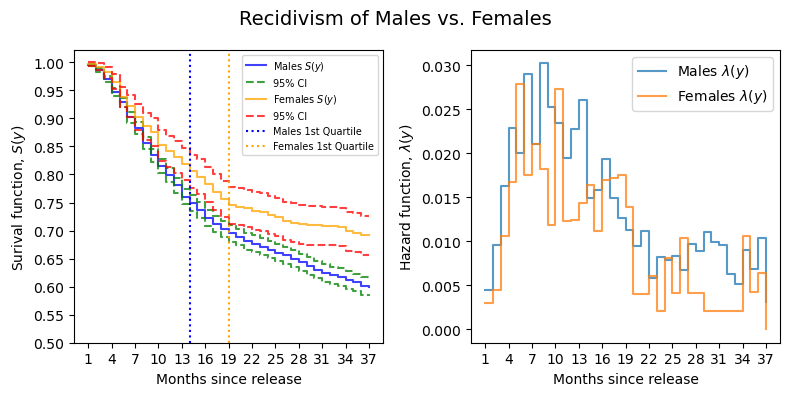

In [41]:
recidivism_tools.plot_survival_hazard(male_life, 'Males', female_life, 'Females')

First, let's examine our survival graph (left plot), which plots the estimated survival functions for both males and females. Our survival graph estimates tell us the probability of avoiding recividism at least as long as the given month. We see that the divergence of male vs. female estimates occurs rather quickly. Almost immediately, the male survival function has a steeper negative slope. This shows in the first quartile (25th percentile) of each group, where the male's is 14 months, and the female's is 19 months. So, by the 14th month post-release, male avoidance of recidivism is estimated to drop to 75%, whereas this occurs by the 19th month for females. The female survival function estimate also seems to flatten out much faster in the later months (starting around month 25), suggesting that once a female individual makes it past this point, there is a far lower likelihood of recidivism. For males, this flattening out is much less extreme, suggesting that even up until the censor point of 3 years, males are still at a comparatively higher risk of recidivism. 

As for our confidence bounds, we see that our bound for the male survival estimate is much tighter than that of the female survival estimate. This is not particularly surprising considering how many more males are in our sample than females (3785 vs. 685). So, our bound is unsurprisingly going to be smaller by construction. However, even taking this into account, our lower bound of our female estimate is roughly around the level of our upper bound of our male estimate (it is a bit lower towards earlier months, but is higher starting around month 10), suggesting that we have statistically significant evidence that the true female survival rate is indeed higher than that of males, particularly after the first 10 months. 

Our hazard graph (right plot) shows the estimated hazard functions, where the hazard function gives us the expected probability that an indvidual will be re-incarcerated, given an individual has avoided re-incarceration up to the given month. In general, we see that the male hazard function is higher than the female hazard function, although there are some exceptions (like months 5 and 10). The differences in the modes of the distribution is quite interesting, suggesting that the peaks of risk of recidivism due differ amongst the sexes. Again, due to our lower sample size for the female estimates, we cannot be as confident in the more granular trends, but it is still an interesting phenomenon nonetheless. The overall pattern remains the same: male recidivism is likely higher than that of females. <br><br>


As for any potential policy implications of this analysis, we see that the highest risk of recidivism across the sexes occurs in the earlier months post-release. So, any potential interventions are likely going to be targeted towards prevention in those early months, whether it be access to employment, mental health resources, etc. Further analysis on the efficacy of potential interventions would be a logical next step in exploring routes to reducing recidivism.

For the sex differential, we can say with confidence that there is a difference between males and females, with the male recidivism rate being higher. For potential reasons, this could be due to different facilities, treatment in said facilities, unobservable differences like higher propensity for crime, etc. In terms of potential further study or policy interventions, diving deeper into these reasons would be well-served, as understanding the underlying causes of such differences could go a long way in determining proper interventions.

### Is there a Supervision Type Differential in Recidivism?

In [42]:
sample['Supervision Type'].value_counts()

Prison          3071
Work Release    1382
Name: Supervision Type, dtype: int64

We will perform identical analysis to above, except conditioning on Supervision Type. This is the only other binary variable we have in our analysis, so this makes it an ideal candidate. What makes it worthwhile analyzing is the fact that while there is one usual category (Prison), the other one, Work Release, is a type of supervision where individuals are allowed to leave the prison for employment, education, or other justified causes. So, observing if being able to leave the prison makes a difference in the duration could motivate work release as a more popular alternative to regular prison, or at the very least more research into its efficacy as an intervention that reduces recidivism. 

For sake of brevity, we will utilize the same functions as above while skipping the intermediate commentary.

In [43]:
# splitting dataframe

prison = sample.loc[sample['Supervision Type'] == 'Prison']
work = sample.loc[sample['Supervision Type'] == 'Work Release'] 

In [44]:
# creating lifetable

prison_life = recidivism_tools.lifetable(prison)
work_life = recidivism_tools.lifetable(work)

prison_life.head(5)

,At risk,Re-incarcerated,Censored
Z,,,
1,3071,13,0
2,3058,20,0
3,3038,39,0
4,2999,50,0
5,2949,62,0


In [45]:
work_life.head(5)

,At risk,Re-incarcerated,Censored
Z,,,
1,1382,6,0
2,1376,19,0
3,1357,29,0
4,1328,45,0
5,1283,28,0


In [46]:
# adding kaplan_meier estimate

recidivism_tools.kaplan_meier(prison_life)
recidivism_tools.kaplan_meier(work_life)
prison_life.head(5)

,Z,At risk,Re-incarcerated,Censored,$\lambda(y)$,$S(y)$
0,1,3071,13,0,0.004233,0.995767
1,2,3058,20,0,0.006540,0.989254
2,3,3038,39,0,0.012837,0.976555
3,4,2999,50,0,0.016672,0.960274
4,5,2949,62,0,0.021024,0.940085


In [47]:
work_life.head(5)

,Z,At risk,Re-incarcerated,Censored,$\lambda(y)$,$S(y)$
0,1,1382,6,0,0.004342,0.995658
1,2,1376,19,0,0.013808,0.981910
2,3,1357,29,0,0.021371,0.960926
3,4,1328,45,0,0.033886,0.928365
4,5,1283,28,0,0.021824,0.908104


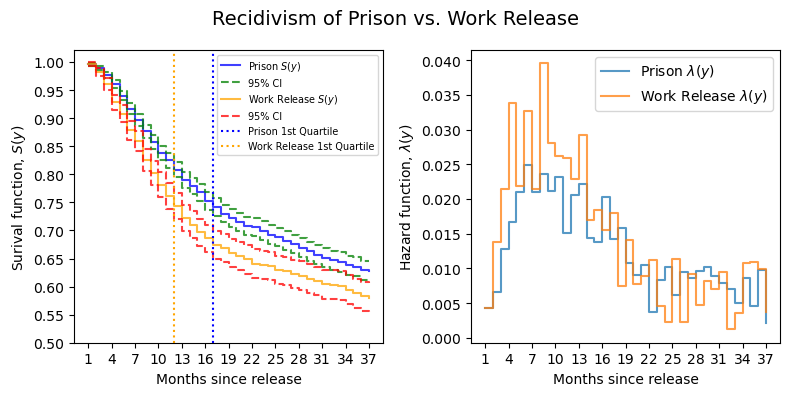

In [48]:
# plotting the survival functions (w/ 95% CIs) and hazard functions

recidivism_tools.plot_survival_hazard(prison_life, 'Prison', work_life, 'Work Release')

First, let's examine our survival graph (left plot), which plots the estimated survival functions for prison and work release. We see that, similar to males and females, the divergence between the two curves happens quickly. Interestingly, the lower one happens to be the work release, which we may have not anticipated given that work release would ostensibly help reduce recividism. Almost immediately, the work release survival function has a steeper negative slope. This shows in the first quartile (25th percentile) of each group, where the work release's is 12 months, and the prison is 17 months. So, by the 12th month post-release, work release avoidance of recidivism is estimated to drop to 75%, whereas this occurs by the 17th month for prison. As for the overall trends, the prison and work curve shapes are rather similar, where the work release curve is basically the prison curve shifted down. There doesn't seem to be much flattening out for either curve like we saw with the female curve, indicating that the recidivism rate is still rather strong by the time of censoring. 

As for our confidence bounds, we see that our bound for the prison survival estimate is tighter than that of the work release survival estimate. This is not particularly surprising considering how many more prison individuals are in our sample than work release (3071 vs. 1382). So, our bound is unsurprisingly going to be smaller by construction. However, even taking this into account, our lower bound of our prison estimate is roughly around the level of our upper bound of our work release estimate (it is a bit lower towards earlier months, but is higher starting around month 7), suggesting that we have statistically significant evidence that the true prison survival rate is indeed higher than that of work release, particularly after the first 7 months. 

Our hazard graph (right plot) shows the estimated hazard functions. In general, we see that the work release hazard function is higher than the prison hazard function, with very view exceptions (like month 16). Unlike the male and female comparison, where there were plenty of points where one group's recidivism risk was higher, here we see that work release is higher for almost the entire observation period. Also, since our sample size is higher for work release, we have more confidence in our bound in comparison to the female bound. So, we can confidently conclude that work release recidivism is higher. <br><br>


As for any potential policy implications of this analysis, across both work release and prison, the early periods post-release show the highest rates of recidivism, like we saw with males vs. females. So, our outtake for this remains the same, in that we want to research interventions that can help individuals in the early post-release period. 

For the supervision type differential, we can say with confidence that there is a difference between prison and work release, with the work release recidivism rate being higher. Considering that this may fly in the face of our intuition, finding reasons behind this phenomenon would be crucial in determining if work release truly doesn't have a positive impact on recidivism. I would definitely like to see more data on the type of work release people were under, to gain a better understanding if there are within-work-release factors that influence recidivism. In terms of potential further study or policy interventions, diving deeper into any of the factors that differentiate work release from prison would be well-served, as understanding the underlying causes of such differences could go a long way in determining if work release is indeed a worthwile alternative to the typical prison sentence in terms of reducing the risk of reoffense.